In [1]:
!python /kaggle/input/dqn-and-attention-mechanism/Path-Planning-based-on-Reinforcement-Learning-master/env.py

In [2]:
!python /kaggle/input/dqn-and-attention-mechanism/Path-Planning-based-on-Reinforcement-Learning-master/Agent.py

In [3]:
!python /kaggle/input/dqn-and-attention-mechanism/Path-Planning-based-on-Reinforcement-Learning-master/DQN.py

number of steps taken by the agent:  438
episode: 0: reward: -1242.50
**********************************************
number of steps taken by the agent:  1302
episode: 1: reward: -4449.00
**********************************************
number of steps taken by the agent:  471
episode: 2: reward: -1537.50
**********************************************
number of steps taken by the agent:  552
episode: 3: reward: -2311.00
**********************************************
number of steps taken by the agent:  423
episode: 4: reward: -1755.00
**********************************************
number of steps taken by the agent:  1034
episode: 5: reward: -3478.00
**********************************************
number of steps taken by the agent:  317
episode: 6: reward: -1005.00
**********************************************
number of steps taken by the agent:  826
episode: 7: reward: -2431.00
**********************************************
number of steps taken by the agent:  405
episode: 8: reward: -

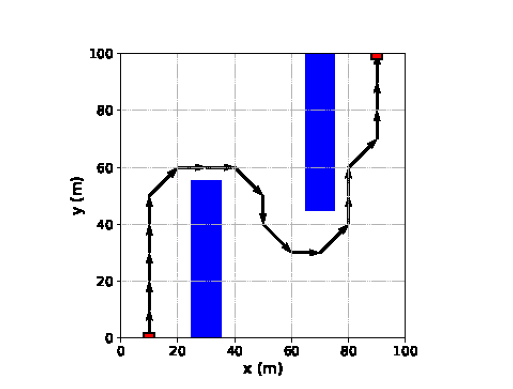

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the EPS image
img = mpimg.imread('/kaggle/working/DQN_Final_Path.eps')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [4]:
%cd /kaggle/input/dqn-and-attention-mechanism/Path-Planning-based-on-Reinforcement-Learning-master

/kaggle/input/dqn-and-attention-mechanism/Path-Planning-based-on-Reinforcement-Learning-master


In [5]:
import torch
import torch.nn as nn  # This is the missing import
import torch.nn.functional as F
import numpy as np

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from env import final_states
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim, hidden):
        super(DQN, self).__init__()
        self.hidden = hidden
        self.conv1 = nn.Conv2d(state_space_dim, 16, 4, 1)
        self.conv2 = nn.Conv2d(16, 32, 4, 1)
        #self.conv3 = nn.Conv2d(32, 64, 3, 1)

        self.channel_attention = ChannelAttention(in_planes=32)
        
        self.fc1 = nn.Linear(5*5*32, 64)
        #self.fc2 = nn.Linear(hidden, 64)
        #self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(64, action_space_dim) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        x = self.channel_attention(x) * x
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, p=0.3)
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        # x = self.fc2(x)
        # x = F.relu(x)
        x = self.fc4(x)
        return x

class DQNAgent(object):
    def __init__(self, state_space, n_actions, replay_buffer_size,
                 batch_size, hidden_size, gamma):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_actions = n_actions
        self.state_space_dim = state_space
        self.policy_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.memory = ReplayMemory(replay_buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma

    def update_network(self, updates=1):
        for _ in range(updates):
            self._do_network_update()

    def _do_network_update(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        #print(type(transitions))
        #print(transitions)
        batch = Transition(*zip(*transitions))
        

        non_final_mask = 1 - torch.tensor(batch.done, dtype=torch.uint8)
        non_final_next_states = [s for nonfinal, s in zip(non_final_mask,
                                                          batch.next_state) if nonfinal > 0]
        #print(non_final_next_states)
        non_final_next_states = torch.stack(non_final_next_states).to(self.device)
        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        self.optimizer.zero_grad()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size).to(self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_values

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values.squeeze(),
                                expected_state_action_values)

        # Optimize the model
        loss.backward()
        for param in self.policy_net.parameters():
            if param.grad is not None:
                param.grad.data.clamp_(-1e-1, 1e-1)
        self.optimizer.step()

    def get_action(self, state, epsilon):
        sample = random.random()
        #print(state)
        #print(state.shape)
        if sample > epsilon:
            with torch.no_grad():
                state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
                q_values = self.policy_net(state).to(self.device)
                return torch.argmax(q_values).item()
        else:
          return random.randrange(self.n_actions)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, next_state, reward, done):
        action = torch.Tensor([[action]]).long()
        reward = torch.tensor([reward], dtype=torch.float32)
        #print(next)
        next_state = torch.from_numpy(next_state).float()
        state = torch.from_numpy(state).float()
        self.memory.push(state, action, next_state, reward, done)

class SarsaTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9):
        # List of actions
        self.actions = actions
        # Learning rate
        self.lr = learning_rate
        # Value of gamma
        self.gamma = reward_decay
        # Creating full Q-table for all cells
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        # Creating Q-table for cells of the final route
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    # Function for choosing the action for the agent
    def get_action(self, observation,epsilon):
        # Checking if the state exists in the table
        self.check_state_exist(observation)
        # Selection of the action - 90 % according to the epsilon == 0.9
        # Choosing the best action
        sample = random.random()
        #print(state)
        #print(state.shape)
        if sample > epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax() #选择表格中Q值最大的action
        else:
            # Choosing random action - left 10 % for choosing randomly
            action = np.random.choice(self.actions) #选择随机的action
        return action

    # Function for learning and updating Q-table with new knowledge
    def learn(self, state, action, reward, next_state,next_state_flag, next_action): #SARSA
        # Checking if the next step exists in the Q-table
        self.check_state_exist(next_state)
        #print(self.q_table)

        # Current state in the current position
        q_predict = self.q_table.loc[state, action]

        # Checking if the next state is free or it is obstacle or goal
        if next_state_flag != 'goal' or next_state_flag != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, next_action] #TD target
        else:
            q_target = reward

        # Updating Q-table with new knowledge，更新Q-table
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    # Adding to the Q-table new states
    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table._append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

    # Printing the Q-table with states
    def print_q_table(self):
        # Getting the coordinates of final route from env.py
        e = final_states()

        # Comparing the indexes with coordinates and writing in the new Q-table values
        for i in range(len(e)):
            state = str(e[i])  # state = '[5.0, 40.0]'
            # Going through all indexes and checking
            for j in range(len(self.q_table.index)):
                if self.q_table.index[j] == state:
                    self.q_table_final.loc[state, :] = self.q_table.loc[state, :]

        print()
        print('Length of final Q-table =', len(self.q_table_final.index))
        print('Final Q-table with values from the final route:')
        print(self.q_table_final)

        print()
        print('Length of full Q-table =', len(self.q_table.index))
        print('Full Q-table:')
        print(self.q_table)


# Creating class for the Q-learning table
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        # List of actions
        self.actions = actions
        # Learning rate
        self.lr = learning_rate
        # Value of gamma
        self.gamma = reward_decay
        # Value of epsilon
        self.epsilon = e_greedy
        # Creating full Q-table for all cells
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        # Creating Q-table for cells of the final route
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    # Function for choosing the action for the agent
    def get_action(self, observation,epsilon):
        # Checking if the state exists in the table
        self.check_state_exist(observation)
        # Selection of the action - 90 % according to the epsilon == 0.9
        # Choosing the best action
        sample = random.random()
        #print(state)
        #print(state.shape)
        if sample > epsilon:
            state_action = self.q_table.loc[observation, :] #提取当前状态下所有动作的价值函数
           # print(state_action)
            state_action = state_action.reindex(np.random.permutation(state_action.index))#打乱顺序，避免每次选择的动作都为序号偏前的动作
           # print(state_action)
            action = state_action.idxmax()
        else:
            # Choosing random action - left 10 % for choosing randomly
            action = np.random.choice(self.actions)
        return action

    # Function for learning and updating Q-table with new knowledge
    def learn(self, state, action, reward, next_state,next_state_flag):
        # Checking if the next step exists in the Q-table 如果不在Q-table中则将其加入到Q-table中
        self.check_state_exist(next_state) 

        # Current state in the current position 
        q_predict = self.q_table.loc[state, action]  #预测的Q值,即目前Q_table内存储的Q值

        # Checking if the next state is free or it is obstacle or goal
        if next_state_flag != 'goal' or next_state_flag != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()  #实际最大值 由动作奖励以及下一状态的最大Q值×折损率组成
        else:
            q_target = reward

        # Updating Q-table with new knowledge
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict) #更新Q值

        return self.q_table.loc[state, action]

    # Adding to the Q-table new states
    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table._append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

    # Printing the Q-table with states
    def print_q_table(self):
        # Getting the coordinates of final route from env.py
        e = final_states()

        # Comparing the indexes with coordinates and writing in the new Q-table values
        for i in range(len(e)):
            state = str(e[i])  # state = '[5.0, 40.0]'
            # Going through all indexes and checking
            for j in range(len(self.q_table.index)):
                if self.q_table.index[j] == state:
                    self.q_table_final.loc[state, :] = self.q_table.loc[state, :]

        print()
        print('Length of final Q-table =', len(self.q_table_final.index))
        print('Final Q-table with values from the final route:')
        print(self.q_table_final)

        print()
        print('Length of full Q-table =', len(self.q_table.index))
        print('Full Q-table:')
        print(self.q_table)


number of steps taken by the agent:  2145
episode: 0: reward: -6981.50
**********************************************
number of steps taken by the agent:  2012
episode: 1: reward: -5621.00
**********************************************
number of steps taken by the agent:  1142
episode: 2: reward: -3801.00
**********************************************
number of steps taken by the agent:  196
episode: 3: reward: -548.50
**********************************************
number of steps taken by the agent:  456
episode: 4: reward: -1720.00
**********************************************
number of steps taken by the agent:  528
episode: 5: reward: -1631.50
**********************************************
number of steps taken by the agent:  64
episode: 6: reward: -148.50
**********************************************
number of steps taken by the agent:  743
episode: 7: reward: -1439.00
**********************************************
number of steps taken by the agent:  1319
episode: 8: reward: -3

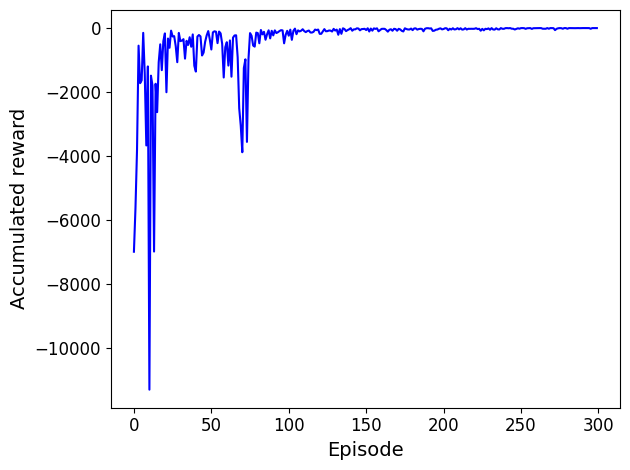

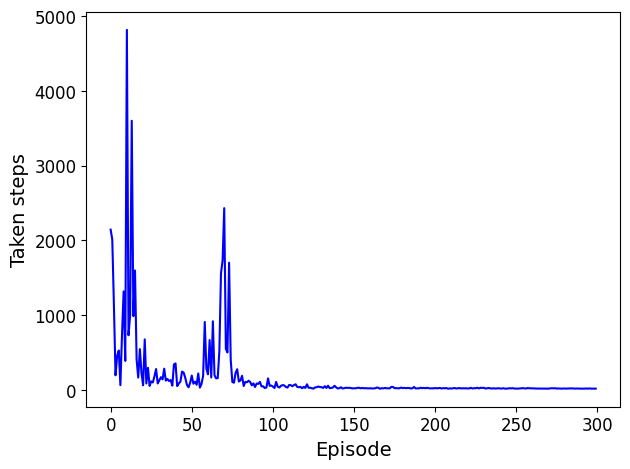

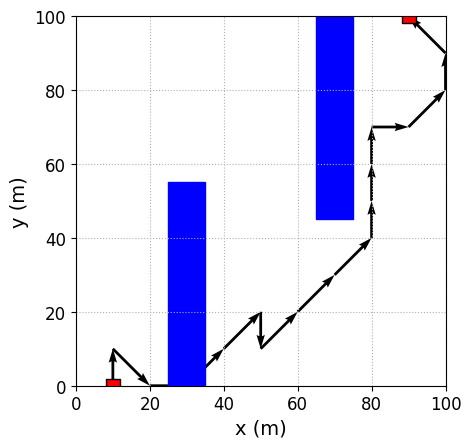

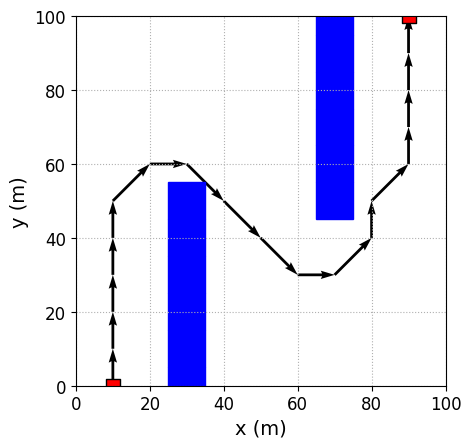

In [7]:
import matplotlib.pyplot as plt
import random
import numpy as np
# from Agent import DQNAgent
from env import Environment
from env import final_states
from env import obstacle_width
import csv
import time

with open('/kaggle/working/iiitp_project_dqn_with_spatial_attention_results.csv','w',newline='') as anish_csvfile:
    anish_writer=csv.writer(anish_csvfile)
    anish_writer.writerow(['ep_no','steps_taken','time_taken','rewards'])
    anish_writer.writerow(['','','',''])

TARGET_UPDATE = 5
num_episodes = 300
hidden = 128
gamma = 0.99
replay_buffer_size = 100000
batch_size = 128
eps_stop = 0.1
epsilon=eps = 0.6
Start_epsilon_decaying = 0
#End_epsilon_decaying = num_episodes // 1
End_epsilon_decaying = num_episodes
epsilon_decaying = epsilon / (End_epsilon_decaying - Start_epsilon_decaying)

n_actions = 8
state_space_dim = 2
starting_position = [10, 0]
target_position=[90,100]
env = Environment( starting_position,target_position, 100, 100, n_actions)

if __name__=="__main__":
    agent = DQNAgent(state_space_dim, n_actions, replay_buffer_size, batch_size,
                 hidden, gamma)
    random.seed(20)
    env.reset()


    # Training loop
    cumulative_rewards = []
    Num_steps = []
    counter_reach_goal = 0

    final_path=[]
    visited_X = [starting_position[0]]
    visited_Y = [starting_position[1]]

    for ep in range(num_episodes):
        start_time_anish = time.time()
        # Initialize the environment and state
        #print('training started ...')
        state = env.reset()
        done = False
        eps -= epsilon_decaying
        epsilon = max(0.01, eps)
        cum_reward = 0
        counter = 0
        number_of_steps_taken_to_terminal = 0
        visited_X_final = []
        visited_Y_final = []


         # visited_X = []
        # visited_Y = []
        
        #print("episode number: ",ep)
        while not done and counter < env.max_episode_steps:
            # if ep % 100 == 0:
            # env.render()
            # Select and perform an action
            action = agent.get_action(state, epsilon)

            visited_X_final.append(env.vector_agentState[0])
            visited_Y_final.append(env.vector_agentState[1])

            next_state,next_state_flag, reward, done, _ = env.step(action)
            #if counter%10 ==0:
            #print(next_state)

            cum_reward += reward
            
            agent.store_transition(state, action, next_state, reward, done) #储存经验
            agent.update_network() #更新策略网络参数

            state = next_state
            counter +=1
            number_of_steps_taken_to_terminal  += 1
        
        #print(state)
        if done:
          end_time_anish = time.time()  
          #print(state)
          print('number of steps taken by the agent: ', number_of_steps_taken_to_terminal)
          Num_steps.append(number_of_steps_taken_to_terminal)
          ###print(env.agentState[-5:])
          ###print(env.Collected_Data)
          
          ###if env.doneType != 0:
            ###print("Type of Terminal done flag: " ,env.doneType)
          cumulative_rewards.append(cum_reward)
          #if ep >= 50:
          #    last50_rewards.append(np.mean(cumulative_rewards[ep - 50:ep]))
          #    last50_steps.append(np.mean(Num_steps[ep -50: ep]))
          ###print("episode: %d: reward: %6.2f, epsilon: %.2f" % ( ep, cum_reward, epsilon))
          print("episode: %d: reward: %6.2f" % ( ep, cum_reward))
          print("**********************************************")
          with open('/kaggle/working/iiitp_project_dqn_with_spatial_attention_results.csv','a',newline='') as anish_file:
                anish_writer=csv.writer(anish_file)
                anish_writer.writerow([ep,number_of_steps_taken_to_terminal,int((end_time_anish-start_time_anish)*1000),cum_reward])

        # Update the target network, copying all weights and biases in DQN
        if ep % TARGET_UPDATE == 0:
            agent.update_target_network() #更新目标网络参数

    env.final()

    plt.figure(tight_layout=True)
    plt.plot(range(num_episodes), cumulative_rewards, label='cumulative rewards', color='b')
    plt.xlabel('Episode',size = '14')
    plt.ylabel('Accumulated reward', size = '14')
    plt.grid(False)
    plt.xticks(size = '12')
    plt.yticks(size = '12')
    #plt.savefig('DQN_Accumulated_Reward.eps',format = 'eps')

    plt.figure(tight_layout=True)
    plt.plot(range(num_episodes), Num_steps, color='b')
    plt.xlabel('Episode',size = '14')
    plt.ylabel('Taken steps', size = '14')
    plt.grid(False)
    plt.xticks(size = '12')
    plt.yticks(size = '12')
    #plt.savefig('DQN_Steps_per_Episode.eps',format = 'eps',dpi=1200) 

    ### Plot the trajectory
    final_path=list(final_states().values())
    print(final_path)
    for i in range(len(final_path)):
        visited_X.append(final_path[i][0])
        visited_Y.append(final_path[i][1])

    ### Plot the trajectory
    x_shortest = np.append(np.array(visited_X), env.Terminal[0])
    y_shortest = np.append(np.array(visited_Y), env.Terminal[1])

    x_final = np.append(np.array(visited_X_final), env.Terminal[0])
    y_final = np.append(np.array(visited_Y_final), env.Terminal[1])
    with open('/kaggle/working/dqnatt_final_path.csv',mode='a',newline='') as anishfile:
        anishwriter = csv.writer(anishfile)
        anishwriter.writerow(x_final)
        anishwriter.writerow(y_final)
    # x_s = np.array([50, 20, 80, 60, 50 ])
    # y_s = np.array([10, 60, 40, 60, 90])

    x_o = env.Obstacle_x 
    y_o = env.Obstacle_y

    plt.figure()

    #绘制矢量场图
    plt.quiver(x_shortest[:-1], y_shortest[:-1], x_shortest[1:]-x_shortest[:-1], y_shortest[1:]-y_shortest[:-1], scale_units='xy', angles='xy', scale=1)

    #plt.scatter(x_s, y_s, c = 'k' ,marker = "o",label = 'Sensor')

    for i in range(len(x_o)):
        rectangle = plt.Rectangle(( 10* (x_o[i]-0.5), 10*(10 - y_o[i] -0.5)), obstacle_width, obstacle_width, fc='blue',ec="blue")
        plt.gca().add_patch(rectangle)

    #plt.scatter(10,10, marker = "s", ec = 'k', c ='red', s=50, label ="Terminal")
    plt.scatter(starting_position[0],starting_position[1], marker = "s", ec = 'k', c ='red', s=100, label ="Start")
    plt.scatter(target_position[0],target_position[1], marker = "s", ec = 'k', c ='red', s =100,label="Target")
    plt.grid(linestyle=':')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel('x (m)',size = '14')
    plt.ylabel('y (m)',size = '14')
    #plt.legend(loc=4)
    plt.xticks(size = '12')
    plt.yticks(size = '12')
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.savefig('DQN_Shortest_Path.eps',format = 'eps')

    plt.figure()
    #绘制矢量场图
    plt.quiver(x_final[:-1], y_final[:-1], x_final[1:]-x_final[:-1], y_final[1:]-y_final[:-1], scale_units='xy', angles='xy', scale=1)

    #plt.scatter(x_s, y_s, c = 'k' ,marker = "o",label = 'Sensor')

    for i in range(len(x_o)):
        rectangle = plt.Rectangle(( 10* (x_o[i]-0.5), 10*(10 - y_o[i] -0.5)), obstacle_width, obstacle_width, fc='blue',ec="blue")
        plt.gca().add_patch(rectangle)

    #plt.scatter(10,10, marker = "s", ec = 'k', c ='red', s=50, label ="Terminal")
    plt.scatter(starting_position[0],starting_position[1], marker = "s", ec = 'k', c ='red', s=100, label ="Start")
    plt.scatter(target_position[0],target_position[1], marker = "s", ec = 'k', c ='red', s =100,label="Target")
    plt.grid(linestyle=':')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel('x (m)',size = '14')
    plt.ylabel('y (m)',size = '14')
    #plt.legend(loc=4)
    plt.xticks(size = '12')
    plt.yticks(size = '12')
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.savefig('DQN_Final_Path.eps',format = 'eps')
    plt.show()







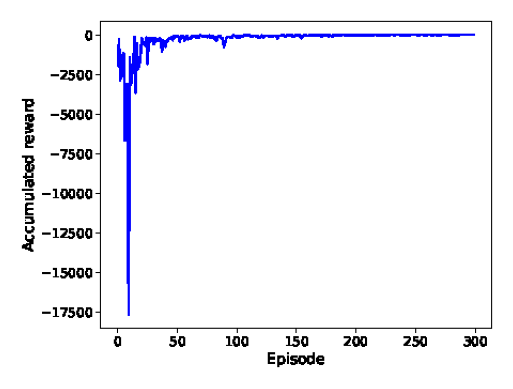

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the EPS image
img = mpimg.imread('/kaggle/working/DQN_Accumulated_Reward.eps')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

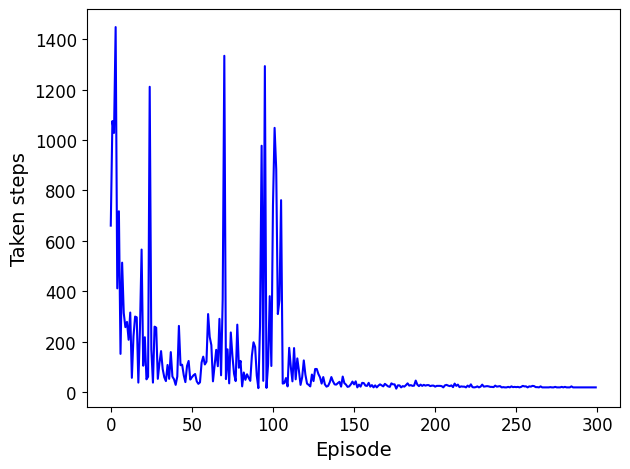

In [16]:
    plt.figure(tight_layout=True)
    plt.plot(range(num_episodes), Num_steps, color='b')
    plt.xlabel('Episode',size = '14')
    plt.ylabel('Taken steps', size = '14')
    plt.grid(False)
    plt.xticks(size = '12')
    plt.yticks(size = '12')
    plt.show

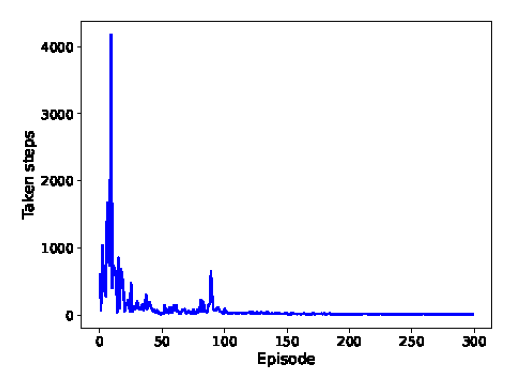

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the EPS image
img = mpimg.imread('/kaggle/working/DQN_Steps_per_Episode.eps')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [30]:
    final_path=list(final_states().values())
    print(final_path)
    for i in range(len(final_path)):
        visited_X.append(final_path[i][0])
        visited_Y.append(final_path[i][1])

    ### Plot the trajectory
    x_shortest = np.append(np.array(visited_X), env.Terminal[0])
    y_shortest = np.append(np.array(visited_Y), env.Terminal[1])

    x_final = np.append(np.array(visited_X_final), env.Terminal[0])
    y_final = np.append(np.array(visited_Y_final), env.Terminal[1])
    # x_s = np.array([50, 20, 80, 60, 50 ])
    # y_s = np.array([10, 60, 40, 60, 90])

    x_o = env.Obstacle_x 
    y_o = env.Obstacle_y

#     plt.figure()

    #绘制矢量场图
#     plt.quiver(x_shortest[:-1], y_shortest[:-1], x_shortest[1:]-x_shortest[:-1], y_shortest[1:]-y_shortest[:-1], scale_units='xy', angles='xy', scale=1)

    #plt.scatter(x_s, y_s, c = 'k' ,marker = "o",label = 'Sensor')

#     for i in range(len(x_o)):
#         rectangle = plt.Rectangle(( 10* (x_o[i]-0.5), 10*(10 - y_o[i] -0.5)), obstacle_width, obstacle_width, fc='blue',ec="blue")
#         plt.gca().add_patch(rectangle)

#     plt.scatter(starting_position[0],starting_position[1], marker = "s", ec = 'k', c ='red', s=100, label ="Start")
#     plt.scatter(target_position[0],target_position[1], marker = "s", ec = 'k', c ='red', s =100,label="Target")
#     plt.grid(linestyle=':')
#     plt.xlim(0,100)
#     plt.ylim(0,100)
#     plt.xlabel('x (m)',size = '14')
#     plt.ylabel('y (m)',size = '14')
#     #plt.legend(loc=4)
#     plt.xticks(size = '12')
#     plt.yticks(size = '12')
#     plt.gca().set_aspect('equal', adjustable='box')
#     plt.show()

[[20, 0], [30, 0], [40, 0], [50, 10], [60, 20], [70, 30], [80, 40], [80, 50], [80, 60], [80, 70], [80, 80], [80, 90], [90, 100]]


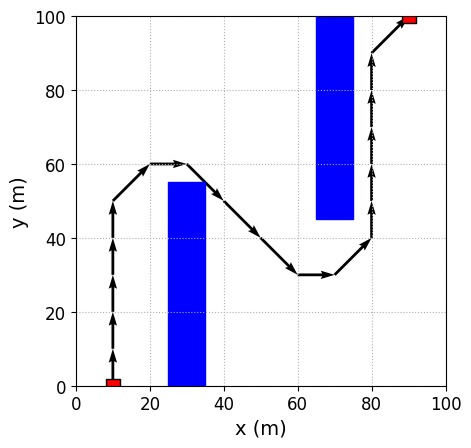

In [31]:
    plt.figure()
    #绘制矢量场图
    plt.quiver(x_final[:-1], y_final[:-1], x_final[1:]-x_final[:-1], y_final[1:]-y_final[:-1], scale_units='xy', angles='xy', scale=1)

    #plt.scatter(x_s, y_s, c = 'k' ,marker = "o",label = 'Sensor')

    for i in range(len(x_o)):
        rectangle = plt.Rectangle(( 10* (x_o[i]-0.5), 10*(10 - y_o[i] -0.5)), obstacle_width, obstacle_width, fc='blue',ec="blue")
        plt.gca().add_patch(rectangle)

    #plt.scatter(10,10, marker = "s", ec = 'k', c ='red', s=50, label ="Terminal")
    plt.scatter(starting_position[0],starting_position[1], marker = "s", ec = 'k', c ='red', s=100, label ="Start")
    plt.scatter(target_position[0],target_position[1], marker = "s", ec = 'k', c ='red', s =100,label="Target")
    plt.grid(linestyle=':')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel('x (m)',size = '14')
    plt.ylabel('y (m)',size = '14')
    #plt.legend(loc=4)
    plt.xticks(size = '12')
    plt.yticks(size = '12')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.savefig('DQN_Final_Path.eps',format = 'eps')
    plt.show()

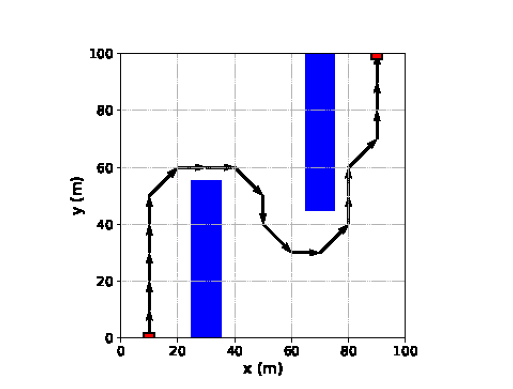

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the EPS image
img = mpimg.imread('/kaggle/working/DQN_Final_Path.eps')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [8]:
!python /kaggle/input/dqn-and-attention-mechanism/Path-Planning-based-on-Reinforcement-Learning-master/Sarsa.py

number of steps taken by the agent:  131
episode: 0: reward: -123.45
**********************************************
number of steps taken by the agent:  199
episode: 1: reward: -74.38
**********************************************
number of steps taken by the agent:  1590
episode: 2: reward: -669.85
**********************************************
number of steps taken by the agent:  287
episode: 3: reward: -138.46
**********************************************
number of steps taken by the agent:  428
episode: 4: reward: -216.71
**********************************************
number of steps taken by the agent:  519
episode: 5: reward: -373.95
**********************************************
number of steps taken by the agent:  836
episode: 6: reward: -647.47
**********************************************
number of steps taken by the agent:  177
episode: 7: reward: -157.85
**********************************************
number of steps taken by the agent:  461
episode: 8: reward: -470.80
***

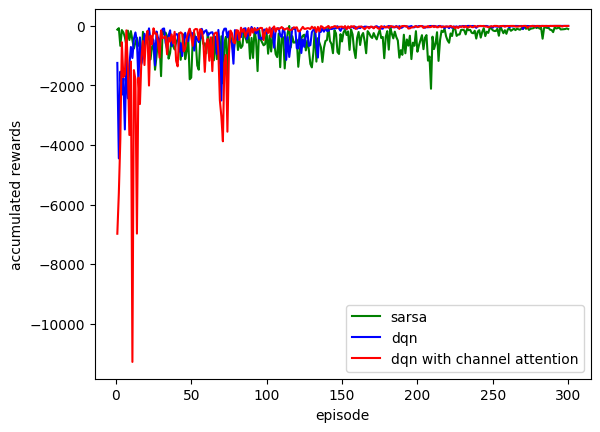

In [9]:
import csv
import matplotlib.pyplot as graph
dqn_acc_rewards = list()
dqn_att_acc_rewards = list()
sarsa_acc_rewards = list()
with open('/kaggle/working/iiitp_project_dqn_results.csv') as file1:
    reader = csv.reader(file1)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:dqn_acc_rewards.append(float(row[3]))
with open('/kaggle/working/iiitp_project_dqn_with_spatial_attention_results.csv') as file2:
    reader = csv.reader(file2)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:dqn_att_acc_rewards.append(float(row[3]))
with open('/kaggle/working/iiitp_project_sarsa_data.csv') as file3:
    reader = csv.reader(file3)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:sarsa_acc_rewards.append(float(row[3]))
graph.plot(list(range(1,min(300,len(sarsa_acc_rewards))+1)), sarsa_acc_rewards[:300], color = 'green', label = 'sarsa')
graph.plot(list(range(1,min(300,len(dqn_acc_rewards))+1)), dqn_acc_rewards[:300], color = 'blue', label = 'dqn')
graph.plot(list(range(1,min(300,len(dqn_att_acc_rewards))+1)), dqn_att_acc_rewards[:300], color = 'red', label = 'dqn with channel attention')
graph.xlabel('episode')
graph.ylabel('accumulated rewards')
graph.title('')
graph.legend()
graph.show()

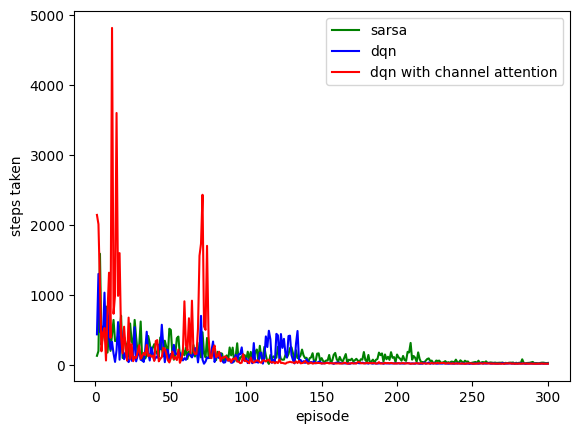

In [10]:
import csv
import matplotlib.pyplot as graph
dqn_acc_rewards = list()
dqn_att_acc_rewards = list()
sarsa_acc_rewards = list()
with open('/kaggle/working/iiitp_project_dqn_results.csv') as file1:
    reader = csv.reader(file1)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:dqn_acc_rewards.append(float(row[1]))
with open('/kaggle/working/iiitp_project_dqn_with_spatial_attention_results.csv') as file2:
    reader = csv.reader(file2)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:dqn_att_acc_rewards.append(float(row[1]))
with open('/kaggle/working/iiitp_project_sarsa_data.csv') as file3:
    reader = csv.reader(file3)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:sarsa_acc_rewards.append(float(row[1]))
graph.plot(list(range(1,min(300,len(sarsa_acc_rewards))+1)), sarsa_acc_rewards[:300], color = 'green', label = 'sarsa')
graph.plot(list(range(1,min(300,len(dqn_acc_rewards))+1)), dqn_acc_rewards[:300], color = 'blue', label = 'dqn')
graph.plot(list(range(1,min(300,len(dqn_att_acc_rewards))+1)), dqn_att_acc_rewards[:300], color = 'red', label = 'dqn with channel attention')
graph.xlabel('episode')
graph.ylabel('steps taken')
graph.title('')
graph.legend()
graph.show()

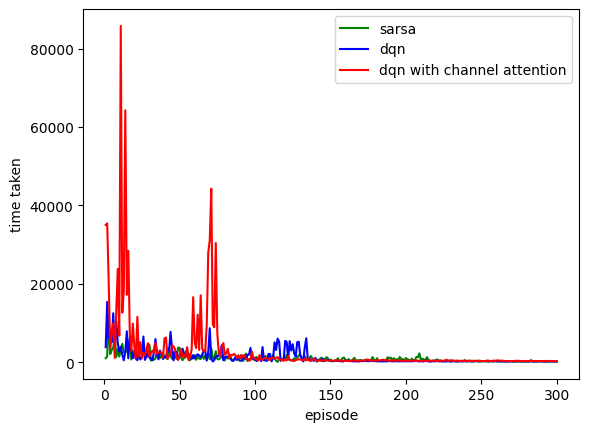

In [11]:
import csv
import matplotlib.pyplot as graph
dqn_acc_rewards = list()
dqn_att_acc_rewards = list()
sarsa_acc_rewards = list()
with open('/kaggle/working/iiitp_project_dqn_results.csv') as file1:
    reader = csv.reader(file1)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:dqn_acc_rewards.append(float(row[2]))
with open('/kaggle/working/iiitp_project_dqn_with_spatial_attention_results.csv') as file2:
    reader = csv.reader(file2)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:dqn_att_acc_rewards.append(float(row[2]))
with open('/kaggle/working/iiitp_project_sarsa_data.csv') as file3:
    reader = csv.reader(file3)
    counter = -1
    for row in reader:
        if counter == 0:break
        counter += 1
    for row in reader:sarsa_acc_rewards.append(float(row[2]))
graph.plot(list(range(1,min(300,len(sarsa_acc_rewards))+1)), sarsa_acc_rewards[:300], color = 'green', label = 'sarsa')
graph.plot(list(range(1,min(300,len(dqn_acc_rewards))+1)), dqn_acc_rewards[:300], color = 'blue', label = 'dqn')
graph.plot(list(range(1,min(300,len(dqn_att_acc_rewards))+1)), dqn_att_acc_rewards[:300], color = 'red', label = 'dqn with channel attention')
graph.xlabel('episode')
graph.ylabel('time taken')
graph.title('')
graph.legend()
graph.show()

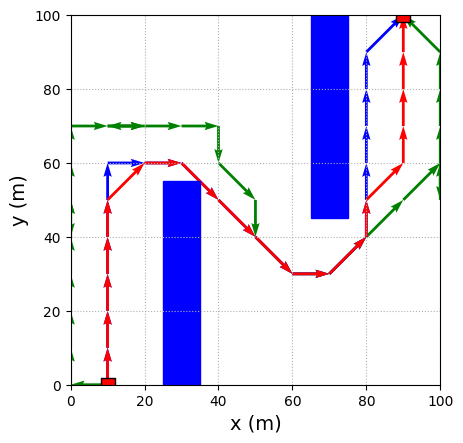

In [13]:
import csv
import matplotlib.pyplot as graph
import numpy
from env import obstacle_width
starting_position = [10,0]
target_position = [90,100]
dqnx = list()
dqny = list()
dqnax = list()
dqnay = list()
sarsax = list()
sarsay = list()
with open('/kaggle/working/common_obstacles.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        x_o = list(map(int,row))
        break
    for row in reader:
        y_o = list(map(int,row))
        break
with open('/kaggle/working/dqn_final_path.csv') as file:
    reader  = csv.reader(file)
    for row in reader:
        dqnx = numpy.array(list(map(int,row)))
        break
    for row in reader:
        dqny = numpy.array(list(map(int,row)))
        break
with open('/kaggle/working/dqnatt_final_path.csv') as file:
    reader  = csv.reader(file)
    for row in reader:
        dqnax = numpy.array(list(map(int,row)))
        break
    for row in reader:
        dqnay = numpy.array(list(map(int,row)))
        break
with open('/kaggle/working/sarsa_final_path.csv') as file:
    reader  = csv.reader(file)
    for row in reader:
        sarsax = numpy.array(list(map(int,row)))
        break
    for row in reader:
        sarsay = numpy.array(list(map(int,row)))
        break
graph.figure()
graph.quiver(sarsax[:-1],sarsay[:-1],sarsax[1:]-sarsax[:-1],sarsay[1:]-sarsay[:-1], scale_units='xy', angles='xy', scale=1, color='green', label='sarsa')
graph.quiver(dqnx[:-1],dqny[:-1],dqnx[1:]-dqnx[:-1],dqny[1:]-dqny[:-1], scale_units='xy', angles='xy', scale=1, color='blue', label='dqn')
graph.quiver(dqnax[:-1],dqnay[:-1],dqnax[1:]-dqnax[:-1],dqnay[1:]-dqnay[:-1], scale_units='xy', angles='xy', scale=1, color='red', label='dqn with channel attention')
for i in range(len(x_o)):
    rectangle = plt.Rectangle(( 10* (x_o[i]-0.5), 10*(10 - y_o[i] -0.5)), obstacle_width, obstacle_width, fc='blue',ec="blue")
    plt.gca().add_patch(rectangle)
graph.scatter(starting_position[0],starting_position[1], marker = "s", ec = 'k', c ='red', s=100, label ="Start")
graph.scatter(target_position[0],target_position[1], marker = "s", ec = 'k', c ='red', s =100,label="Target")
graph.grid(linestyle=':')
graph.xlim(0,100)
graph.ylim(0,100)
graph.xlabel('x (m)',size = '14')
graph.ylabel('y (m)',size = '14')
graph.gca().set_aspect('equal', adjustable='box')
graph.show()

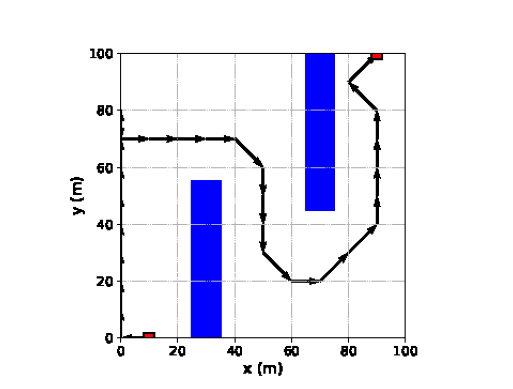

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the EPS image
img = mpimg.imread('/kaggle/working/SARSA_Final_Path.eps')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

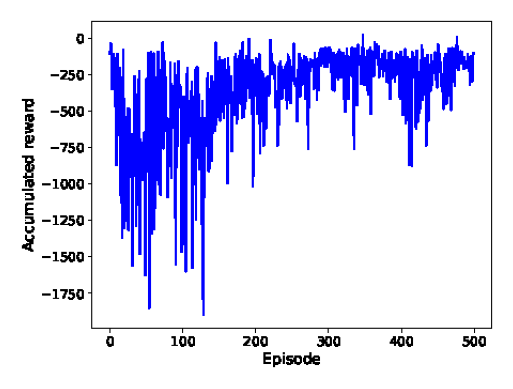

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the EPS image
img = mpimg.imread('/kaggle/working/SARSA_Accumulated_Reward.eps')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

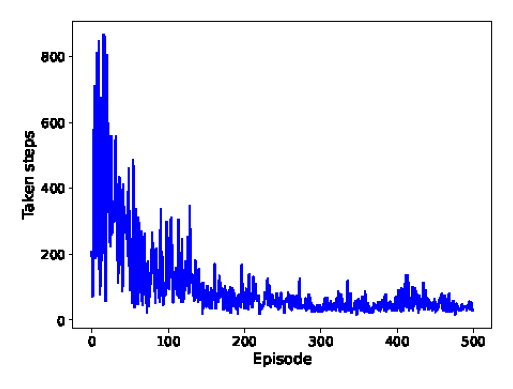

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the EPS image
img = mpimg.imread('/kaggle/working/SARSA_Steps_per_Episode.eps')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()